# Projekt: Erkennung von Spurmarkierungen
In diesem Projekt sollen Spurmarkierungen in zwei bestehenden Datensätzen erkannt werden: 
1. Udacity Nanodegree "Self-Driving Car Engineer" (https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd0013)
2. KITTI-Datensatz zur Erkennung von Spurmarkierungen (http://www.cvlibs.net/datasets/kitti/eval_road.php)

In [2]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import os
import glob
import time

print('Willkommen beim Projekt "Erkennung von Spurmarkierungen"')

Willkommen beim Projekt "Erkennung von Spurmarkierungen"


### Laden des Videos
In diesem Schritt wird das Video geladen und mit seinen FPS angezeigt.

In [156]:
# Path to video
video = "img/Udacity/project_video.mp4"
videoHarder = "img/Udacity/challenge_video.mp4"
videoHardest = "img/Udacity/harder_challenge_video.mp4"

# Load video
video = cv.VideoCapture(video)
prev_frame_time = 0
new_frame_time = 0

# Window size
win_x = 1280
win_y = 720

# While the video is running
while(video.isOpened()):
    ret, frame = video.read()

    # Break if video is finish or no input
    if not ret:
        break
    
    # Do here the image processing
    # frame = cv.Canny(frame, 100, 150)

    # Do operations on the frame
    gray = frame
    gray = cv.resize(gray, (win_x, win_y))
    transformed = transform_image_perspective(gray)
    gray = set_points_in_picture(gray)
    font = cv.FONT_HERSHEY_SIMPLEX
    new_frame_time = time.time()

    # Calculate Frame Rate
    fps = 1/(new_frame_time-prev_frame_time)
    prev_frame_time = new_frame_time
    fps = int(fps)
    fps = str(fps)

    # Put fps on the screen
    cv.putText(gray, fps, (7, 21), font, 1, (100, 100, 100), 2, cv.LINE_AA)
    cv.putText(transformed, fps, (7, 21), font, 1, (100, 100, 100), 2, cv.LINE_AA)

    cv.imshow('Video', gray)
    cv.imshow('transformed', transformed)

    # press 'Q' for exit
    if cv.waitKey(1) & 0xFF == ord('q'):
        break


# Stop video and close window
video.release()
cv.destroyAllWindows()

# Exkurs 1: Kamerakalibrierung zur Entzerrung der Bilder
Die vorhandenen Bilder sind aufgrund der Linsen- und Kameraeigenschaften verzerrt. Entzerren Sie die Bilder mithilfe der Kamerakalibrierungsroutinen von OpenCV (https://docs.opencv.org/4.5.3/dc/dbb/tutorial_py_calibration.html) und den aufgezeichneten Bildern.

In [4]:

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

grid_size = (9, 6)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((grid_size[0] * grid_size[1],3), np.float32)
objp[:,:2] = np.mgrid[0:grid_size[0],0:grid_size[1]].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# read the chessboard imag
images = glob.glob('./img/Udacity/calib/*.jpg')
# images = [
#     'img/Udacity/calib/calibration1.jpg',
#     ]
for file_name in images:
    board = cv.cvtColor(cv.imread(file_name), cv.COLOR_BGR2RGB)
    gray_board = cv.cvtColor(board, cv.COLOR_RGB2GRAY)

    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray_board, grid_size, None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray_board,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)

        # Draw and display the corners
        cv.drawChessboardCorners(board, grid_size, corners2, ret)
        cv.imshow("img", board)
        print(file_name)
        if cv.waitKey(100) & 0xFF == ord('q'):
                break

cv.destroyAllWindows()

./img/Udacity/calib\calibration10.jpg
./img/Udacity/calib\calibration11.jpg
./img/Udacity/calib\calibration12.jpg
./img/Udacity/calib\calibration13.jpg
./img/Udacity/calib\calibration14.jpg
./img/Udacity/calib\calibration15.jpg
./img/Udacity/calib\calibration16.jpg
./img/Udacity/calib\calibration17.jpg
./img/Udacity/calib\calibration18.jpg
./img/Udacity/calib\calibration19.jpg
./img/Udacity/calib\calibration2.jpg
./img/Udacity/calib\calibration20.jpg
./img/Udacity/calib\calibration3.jpg
./img/Udacity/calib\calibration6.jpg
./img/Udacity/calib\calibration7.jpg
./img/Udacity/calib\calibration8.jpg
./img/Udacity/calib\calibration9.jpg


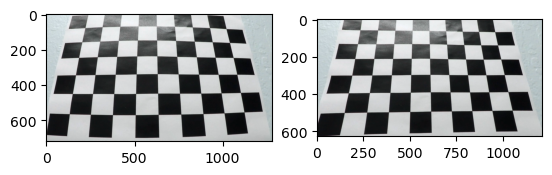

In [5]:
# Generate the matrix and distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray_board.shape[::-1], None, None)

img = cv.imread('img/Udacity/calib/calibration3.jpg')
h,  w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1,2, 2)
plt.imshow(dst)


In [6]:
# Get the Re-projection error rate. This is the average distance between the
# predicted and actual points. The lower the error, the better the fit.
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)) )

total error: 0.10841458014053888


# Exkurs 2: Perspektivtransformation
Durch die Kameraperspektive wird die Krümmung der gefundenen Spurmarkierungen nicht der realen Fahrstreifenkrümmung entsprechen. Transformieren Sie daher die Bilder der Kameraperspektive in eine Vogelperspektive, die der realen Fahrstreifenkrümmung entspricht.

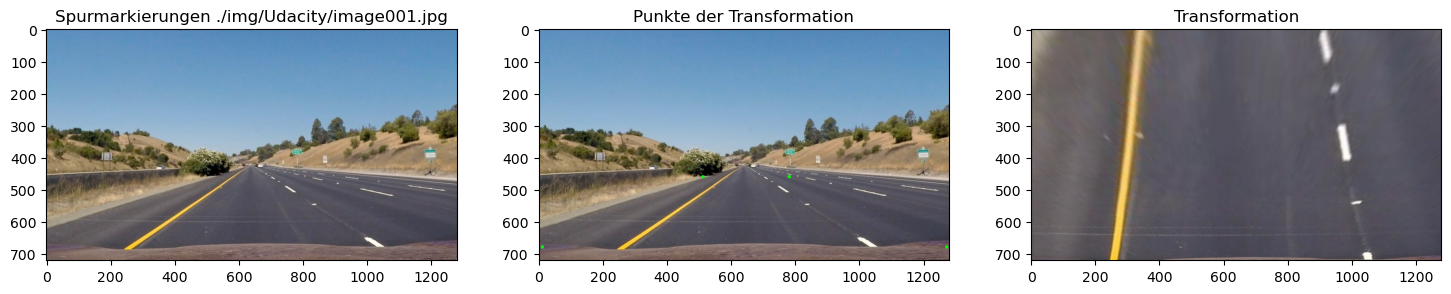

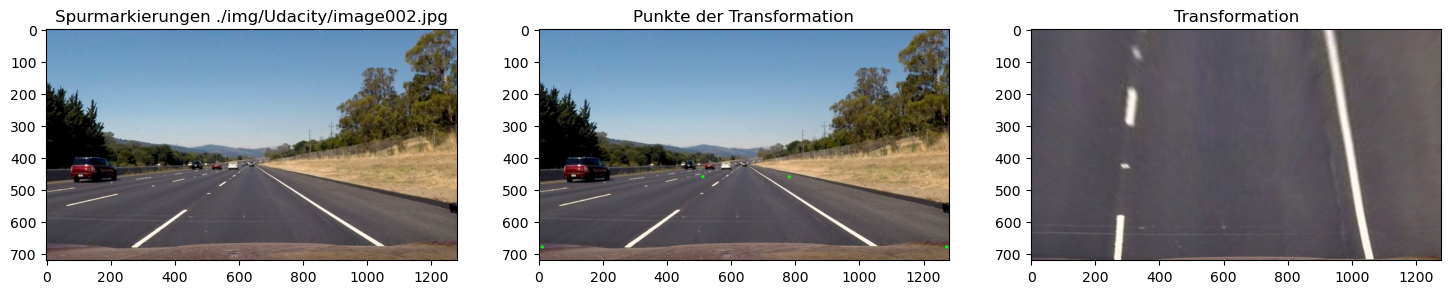

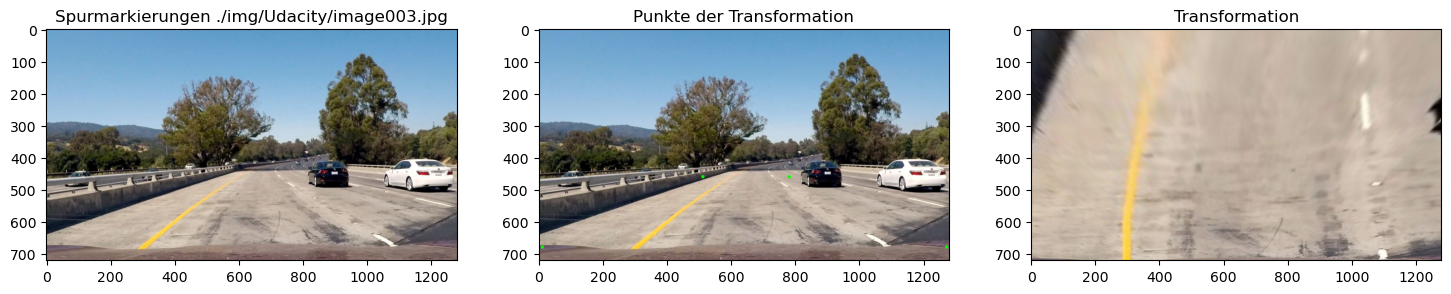

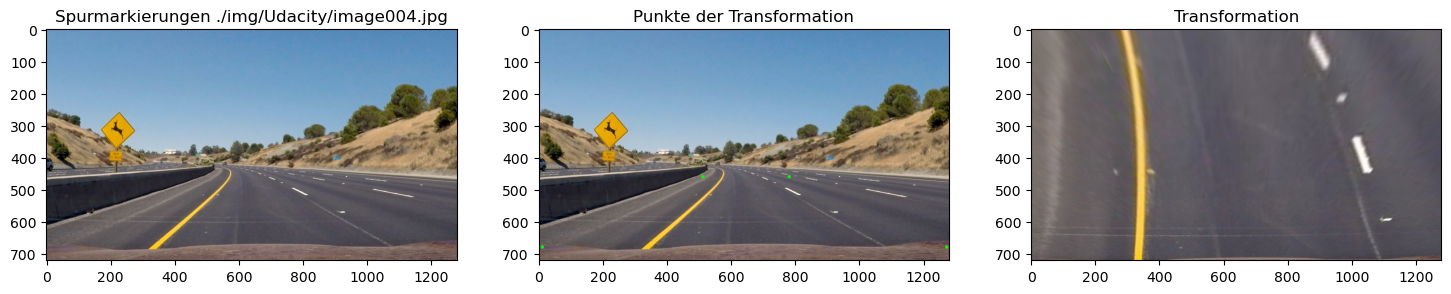

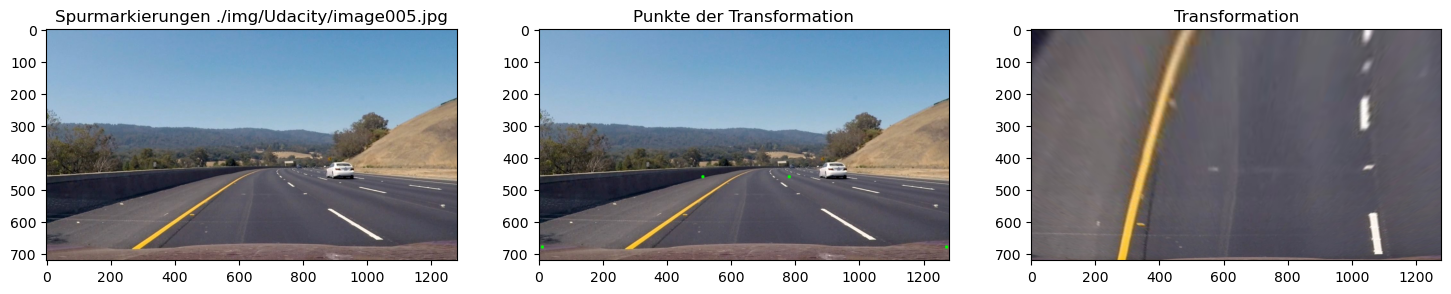

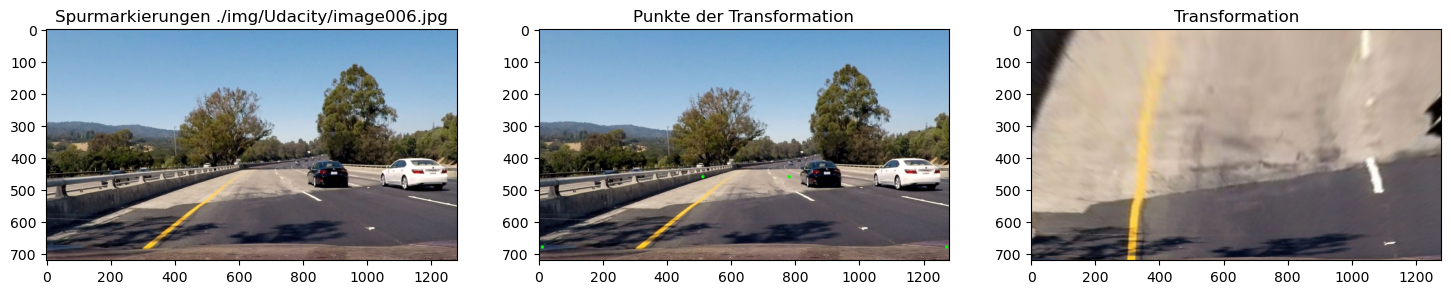

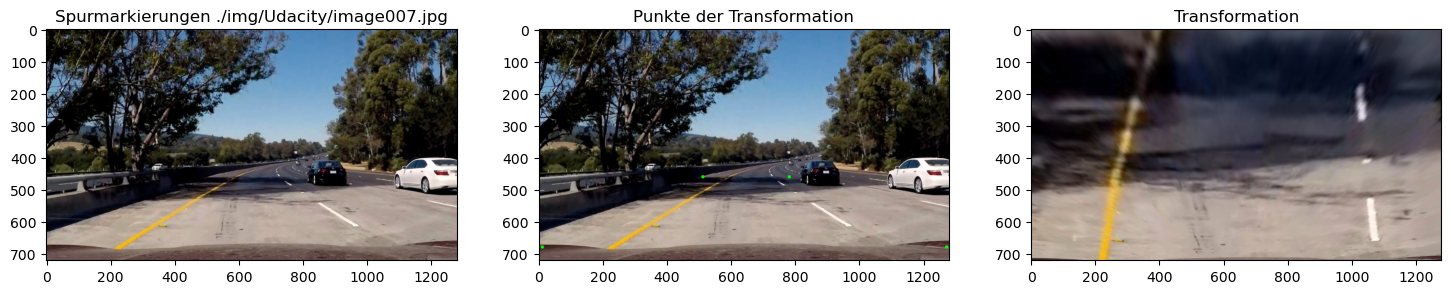

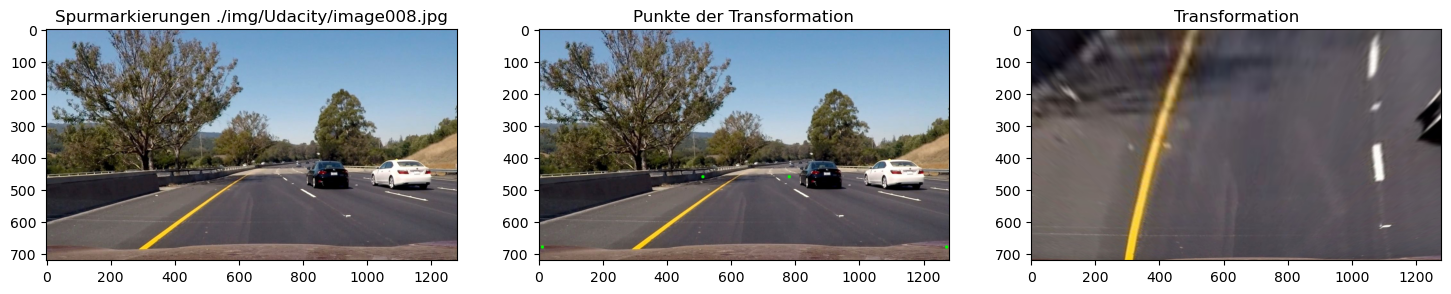

In [158]:
def get_transformation_coordinates(height, width):
    #first x coordinate, then y (yes confusing)
    src_top_left = [510, 460]
    src_top_right = [width-500, 460]
    src_bot_left = [10, height-40]
    src_bot_right = [width-10,height-40]
    src = [src_top_left, src_top_right, src_bot_left, src_bot_right]

    dst_top_left = [0,0]
    dst_top_right = [width,0]
    dst_bot_left = [0,height]
    dst_bot_right = [width,height]
    dst = [dst_top_left, dst_top_right, dst_bot_left, dst_bot_right]

    return src, dst


def calculate_matrix(img):

    height = len(img1) -1
    width = len(img1[0]) -1

    src_coor, dst_coor = get_transformation_coordinates(height, width)
    src = np.float32([src_coor[0], src_coor[1], src_coor[2], src_coor[3]]) 
    dst = np.float32([dst_coor[0], dst_coor[1], dst_coor[2], dst_coor[3]])

    M = cv.getPerspectiveTransform(src,dst)
    M_reversed = cv.getPerspectiveTransform(dst,src)
    return M, M_reversed

def transform_image_perspective(img):
    M, M_reversed = calculate_matrix(img)

    img_transformed = cv.warpPerspective(img,M,(img.shape[1], img.shape[0]),flags=cv.INTER_LINEAR)

    return img_transformed


def set_points_in_picture(img):
    height = len(img1) -1
    width = len(img1[0]) -1

    src_coor, _ = get_transformation_coordinates(height, width)
    src = np.float32([src_coor[0], src_coor[1], src_coor[2], src_coor[3]])

    for val in src: 
        cv.circle(img,(int(val[0]),int(val[1])),5,(0,255,0),-1)
   
    return img

for i in range(1,9):
    name = './img/Udacity/image00'+ str(i) +'.jpg'
    plt.figure(figsize = (18, 6))

    plt.subplot(1,3,1)
    img1 = cv.imread(name, -1)
    plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
    plt.title('Spurmarkierungen ' + name)

    plt.subplot(1,3,2)
    img1_points = set_points_in_picture(cv.imread(name, -1))
    plt.imshow(cv.cvtColor(img1_points, cv.COLOR_BGR2RGB))
    plt.title('Punkte der Transformation')

    plt.subplot(1,3,3)
    img1_warp = transform_image_perspective(img1)
    plt.imshow(cv.cvtColor(img1_warp, cv.COLOR_BGR2RGB))
    plt.title('Transformation')
    plt.show()

# Aufgabe 3: Erkennung von Fahrbahnmarkierungen
Erkennen Sie die Fahrbahnmarkierungen bzw. Fahrstreifen auf den Bildquellen von Udacity. Wenden Sie dabei die aus der Vorlesung bekannten Verfahren an. Gerne dürfen Sie auch weitere Verfahren aus anderen Quellen verwenden. Folgende Ziele müssen bei der finalen Abgabe erreicht werden: 
- **Segmentierung**: schränken Sie das Bild auf den Bereich ein, in dem sich die Spurmarkierungen befinden
- **Vorverarbeitung**: führen Sie eine Kamerakalibrierung (für Udacity-Bildquellen) und die Perspektivtransformation durch
- **Farbräume, Histogramme**: erkennen Sie die Spurmarkierungen in den Farben der angegebenen Quellen. Sofern weitere Spurmarkierungen auf dem Bild gefunden werden, müssen diejenigen Spurmarkierungen priorisiert werden, die die eigene Fahrspur begrenzen
- **Allgemeines**: Die Verarbeitung von Bildern muss in Echtzeit stattfinden --> Ziel: > 20 FPS
- **Allgemeines**: Beschleunigen Sie die Verarbeitung durch weitere Maßnahmen weitere Maßnahmen überlegen (bspw. Erkennung der Spurmarkierung in den ersten Frames, Tracking der Spurmarkierung in weiteren Frames solange, bis sich Spurmarkierungspositionen zu stark ändern)
- **Minimal**: relevante Spurmarkierungen werden im Video "project_video" durchgehend erkannt 
- **Zusatz**: relevante Spurmarkierungen werden im Video "challenge_video" und "harder_challenge_video" durchgehend erkannt
- **Zusatz**: relevante Spurmarkierungen werden auf den Datensatz KITTI angewendet. Welche Anpassungen müssen vorgenommen werden, damit Ihr Algorithmus übertragen werden kann?
- **Zusatz**: Erarbeiten Sie weitere Maßnahmen zur Geschwindigkeitsverbesserung Ihres Algorithmus
- **Zusatz**: Erkennen Sie Objekte im Bild und visualisieren Sie diese (z.B. weitere Fahrzeuge, Motorräder, etc.)Die Objekterkennung bitte so implementieren, dass sie deaktivierbar ist und nicht in FPS-Berechnung einzahlt.

## Gray scaling and edge detection
The goal is to detect the edges of the lines in the field of interest
(FOI). For this we gray scale the image first, so that the color
information is replaced by the intensity information. Afterwards we
apply Canny edge for detecting the edges. To not detect the edge of
the segmentation, we first convert the picture

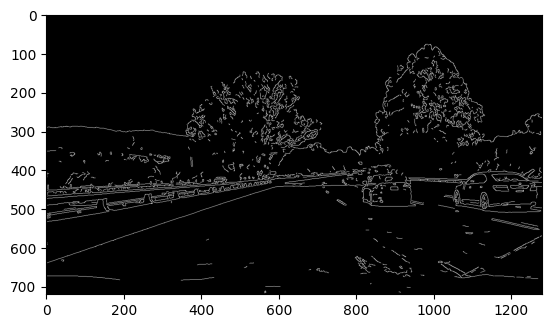

In [ ]:

# img = cv.imread('img/Udacity/image001.jpg', cv.COLOR_BGR2RGB)
# img = cv.imread('img/Udacity/image002.jpg', cv.COLOR_BGR2RGB)
img = cv.imread('img/Udacity/image003.jpg', cv.COLOR_BGR2RGB)
# img = cv.imread('img/Udacity/image004.jpg', cv.COLOR_BGR2RGB)

# Gray scale the image
gray_img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

# Gaussian blur the image
gray_img = cv.GaussianBlur(gray_img, (5,5), 0)

# Canny edge detection
canny_img = cv.Canny(gray_img, 100, 150)

plt.figure()
plt.imshow(canny_img, cmap='gray')
plt.show()

## Segmentation of the image
In the segmentation, the image is divided into different arias. The
goal is to have a defined aria for searching lanes. In our case it is
a triangle in the bottom of the frame to the center of the frame.

[(0, 645), (615.0, 420.0), (1230, 645)]


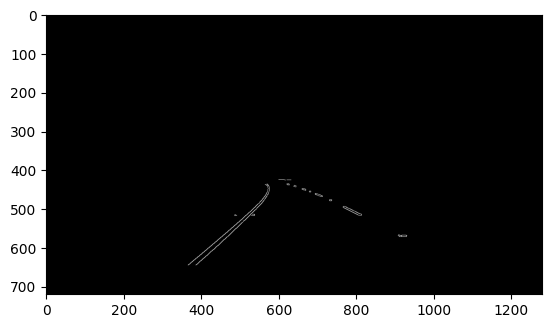

In [ ]:
# Segmentation of the image into different FOI
def region_of_interest(img, vertices):
    # Define a blank matrix that matches the image height/width.
    mask = np.zeros_like(img)

    match_mask_color = 255
      
    # Fill inside the polygon
    cv.fillPoly(mask, vertices, match_mask_color)
    
    # Returning the image only where mask pixels match
    masked_image = cv.bitwise_and(img, mask)
    return masked_image

dim = canny_img.shape
height = dim[0]
width = dim[1]

# Define region
region_of_interest_vertices = [
    (0, height - 75),
    ((width -50) / 2, (height + 120) / 2),
    (width - 50, height - 75),
]
print(region_of_interest_vertices)

# Apply the region of interest
img_region = region_of_interest(canny_img, np.array([region_of_interest_vertices], np.int32))
plt.figure()
plt.imshow(img_region, cmap='gray')
plt.show()

Now we have the edges without the edge of the aria

## Hough Transformation
The hough transformation detects the lines in the picture.

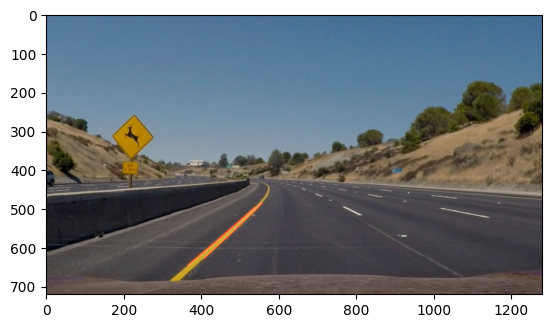

In [ ]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    # If there are no lines to draw, exit.
    if lines is None:
        return    # Make a copy of the original image.
    img = np.copy(img)    # Create a blank image that matches the original in size.
    line_img = np.zeros(
        (
            img.shape[0],
            img.shape[1],
            3
        ),
        dtype=np.uint8,
    )    # Loop over all lines and draw them on the blank image.
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv.line(line_img, (x1, y1), (x2, y2), color, thickness)    # Merge the image with the lines onto the original.
    img = cv.addWeighted(img, 0.8, line_img, 1.0, 0.0)    # Return the modified image.
    return img

lines = cv.HoughLinesP(
    img_region,
    rho=2,
    theta=np.pi / 180,
    threshold=100,
    lines=np.array([]),
    minLineLength=40,
    maxLineGap=5
)
line_image = draw_lines(cv.cvtColor(img, cv.COLOR_BGR2RGB), lines)
plt.imshow(line_image)
plt.show()

# Ausblick auf weitere Teilaufgaben
- Bestimmung der Kurvenkrümmung anhand von Polynom-Fiting

# References
This references are used to inform about the project and some code
snippets are used in the project:
- https://medium.com/@mrhwick/simple-lane-detection-with-opencv-bfeb6ae54ec0
  (Segmentation and Hugh Transformation)
- https://towardsdatascience.com/a-deep-dive-into-lane-detection-with-hough-transform-8f90fdd1322f
  (Segmentation and Hugh Transformation)
  